# LogisticRegression

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
import time
import json
import config as cfg

from category_encoders import WOEEncoder
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    cross_validate,
    cross_val_score
)

cv_dev = StratifiedKFold(n_splits=cfg.N_SPLITS, shuffle=True, random_state=cfg.SEED)
cv_test = RepeatedStratifiedKFold(n_splits=cfg.N_SPLITS, n_repeats=cfg.N_REPEATS, random_state=cfg.SEED)

np.set_printoptions(formatter={"float": lambda x: "{0:0.4f}".format(x)})
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

sns.set_context("paper", font_scale=1.4)
sns.set_style("darkgrid")

In [2]:
MODEL_NAME = 'LogisticRegression'

In [3]:
# Load data
X_train = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "X_train.csv"))
X_test = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "X_test.csv"))
y_train = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "y_train.csv"))
y_test = pd.read_csv(os.path.join("Data", "data_preprocessed_binned", "y_test.csv"))

X_train

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,"(0.699, 0.981]","(33.0, 39.0]","[0, 1)","(0.649, 4.0]","(2005.0, 3000.0]","(10.0, 12.0]","[0, 1)","[1, 2)","[0, 1)","[2, 3)"
1,"(-0.001, 0.00297]","(33.0, 39.0]","[1, 100)","(1267.0, 329664.0]",NaN,"(3.0, 4.0]","[0, 1)","[1, 2)","[0, 1)","[0, 1)"
2,"(0.445, 0.699]","(-0.001, 33.0]","[0, 1)","(0.468, 0.649]","(3800.0, 4544.2]","(8.0, 9.0]","[0, 1)","[1, 2)","[0, 1)","[0, 1)"
3,"(0.445, 0.699]","(33.0, 39.0]","[1, 100)","(0.0309, 0.134]","(3000.0, 3800.0]","(-0.001, 3.0]","[1, 100)","[0, 1)","[0, 1)","[0, 1)"
4,"(0.271, 0.445]","(65.0, 72.0]","[0, 1)","(0.468, 0.649]","(3000.0, 3800.0]","(15.0, 58.0]","[0, 1)","[0, 1)","[0, 1)","[0, 1)"
...,...,...,...,...,...,...,...,...,...,...
15870,"(0.981, 50708.0]","(44.0, 48.0]","[1, 100)","(0.134, 0.214]","(4544.2, 5400.0]","(15.0, 58.0]","[0, 1)","[0, 1)","[1, 100)","[2, 3)"
15871,"(0.00297, 0.0192]","(61.0, 65.0]","[0, 1)","(0.134, 0.214]","(4544.2, 5400.0]","(10.0, 12.0]","[0, 1)","[1, 2)","[0, 1)","[1, 2)"
15872,"(0.445, 0.699]","(-0.001, 33.0]","[1, 100)","(0.214, 0.287]","(2005.0, 3000.0]","(3.0, 4.0]","[1, 100)","[0, 1)","[1, 100)","[0, 1)"
15873,"(0.0832, 0.154]","(48.0, 52.0]","[0, 1)","(0.287, 0.367]","(3800.0, 4544.2]","(6.0, 8.0]","[0, 1)","[1, 2)","[0, 1)","[0, 1)"


### Feature selection

In [4]:
# Sequential feature selection
model = Pipeline([("encoder", WOEEncoder()), ("lr", LogisticRegression(random_state=cfg.SEED))])

if cfg.SFS_VAR == -1:
    sfs_iter = X_train.shape[1]
else:
    sfs_iter = cfg.SFS_VAR

sfs = SequentialFeatureSelector(
    model,
    k_features=(1, sfs_iter),
    forward=True,
    floating=True,
    scoring="roc_auc",
    verbose=2,
    cv=cv_dev,
    n_jobs=-1,
)

sfs = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished

[2021-09-26 03:57:37] Features: 1/10 -- score: 0.7816665234220813[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished

[2021-09-26 03:57:39] Features: 2/10 -- score: 0.8165180106191986[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    1.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2

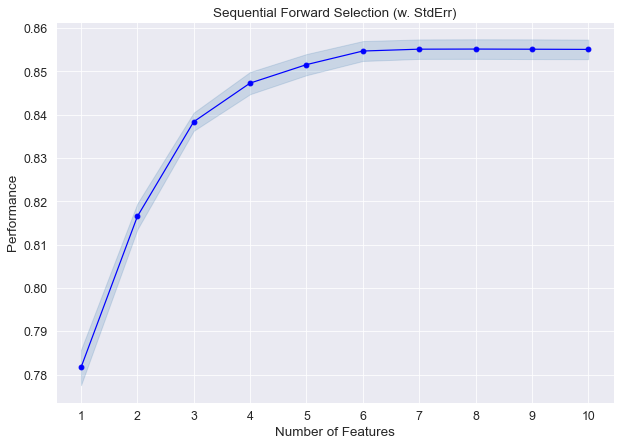

In [5]:
# Plot SFS chart
fig = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize=[10, 7])
plt.title("Sequential Forward Selection (w. StdErr)")

plt.savefig(os.path.join("Graphs", f"SFS_{MODEL_NAME}.png"), facecolor="w", dpi=100, bbox_inches = "tight")

In [6]:
for c in X_train.iloc[:, list(sfs.k_feature_idx_)].columns:
    print(c)

RevolvingUtilizationOfUnsecuredLines
age
NumberOfTime30-59DaysPastDueNotWorse
DebtRatio
NumberOfTimes90DaysLate
NumberRealEstateLoansOrLines
NumberOfTime60-89DaysPastDueNotWorse
NumberOfDependents


In [7]:
# Drop unused variables
X_train = X_train.iloc[:, list(sfs.k_feature_idx_)]
X_test = X_test.iloc[:, list(sfs.k_feature_idx_)]
X_train

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,"(0.699, 0.981]","(33.0, 39.0]","[0, 1)","(0.649, 4.0]","[0, 1)","[1, 2)","[0, 1)","[2, 3)"
1,"(-0.001, 0.00297]","(33.0, 39.0]","[1, 100)","(1267.0, 329664.0]","[0, 1)","[1, 2)","[0, 1)","[0, 1)"
2,"(0.445, 0.699]","(-0.001, 33.0]","[0, 1)","(0.468, 0.649]","[0, 1)","[1, 2)","[0, 1)","[0, 1)"
3,"(0.445, 0.699]","(33.0, 39.0]","[1, 100)","(0.0309, 0.134]","[1, 100)","[0, 1)","[0, 1)","[0, 1)"
4,"(0.271, 0.445]","(65.0, 72.0]","[0, 1)","(0.468, 0.649]","[0, 1)","[0, 1)","[0, 1)","[0, 1)"
...,...,...,...,...,...,...,...,...
15870,"(0.981, 50708.0]","(44.0, 48.0]","[1, 100)","(0.134, 0.214]","[0, 1)","[0, 1)","[1, 100)","[2, 3)"
15871,"(0.00297, 0.0192]","(61.0, 65.0]","[0, 1)","(0.134, 0.214]","[0, 1)","[1, 2)","[0, 1)","[1, 2)"
15872,"(0.445, 0.699]","(-0.001, 33.0]","[1, 100)","(0.214, 0.287]","[1, 100)","[0, 1)","[1, 100)","[0, 1)"
15873,"(0.0832, 0.154]","(48.0, 52.0]","[0, 1)","(0.287, 0.367]","[0, 1)","[1, 2)","[0, 1)","[0, 1)"


### Test performance

test_gini:	 0.7111
test_ap:	 0.366


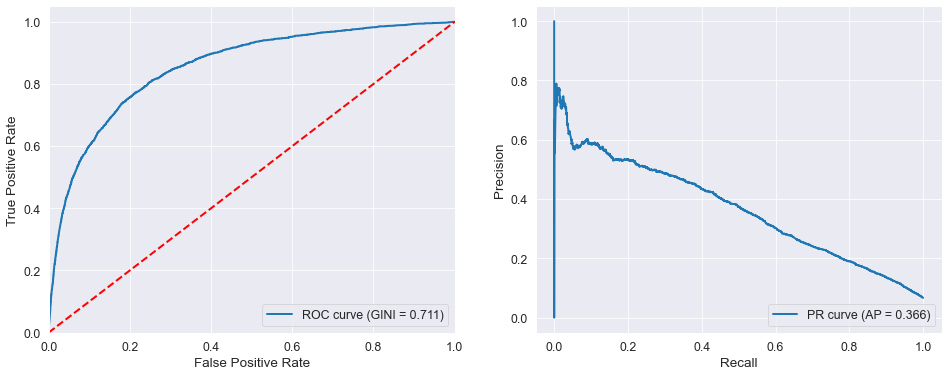

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

model = Pipeline([("encoder", WOEEncoder()), ("lr", LogisticRegression(random_state=cfg.SEED))])
model.fit(X = X_train, y = np.ravel(y_train))

# Calculate metrics
preds = model.predict_proba(X_test)[::,1]
test_gini = metrics.roc_auc_score(y_test, preds)*2-1
test_ap = metrics.average_precision_score(y_test, preds)
print(f"test_gini:\t {test_gini:.4}")
print(f"test_ap:\t {test_ap:.4}")

# ROC
test_auc = metrics.roc_auc_score(y_test, preds)

fpr, tpr, _ = metrics.roc_curve(y_test, preds)
lw = 2
axs[0].plot(fpr, tpr, lw=lw, label="ROC curve (GINI = %0.3f)" % test_gini)
axs[0].plot([0, 1], [0, 1], color="red", lw=lw, linestyle="--")
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("True Positive Rate")
axs[0].legend(loc="lower right")

# PR
precision, recall, _ = metrics.precision_recall_curve(y_test, preds)
lw = 2
axs[1].plot(recall, precision, lw=lw, label="PR curve (AP = %0.3f)" % test_ap)
axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].legend(loc="lower right")

plt.savefig(os.path.join("Graphs", f"ROC_PRC_{MODEL_NAME}.png"), facecolor="w", dpi=100, bbox_inches = "tight")

In [9]:
# Cross-validation GINI
scores_gini = cross_validate(
    model, X_train, np.ravel(y_train), scoring="roc_auc", cv=cv_test, return_train_score=True, n_jobs=-1
)

mean_train_gini = (scores_gini["train_score"]*2-1).mean()
mean_test_gini = (scores_gini["test_score"]*2-1).mean()
std_test_gini = (scores_gini["test_score"]*2-1).std()

print(f"mean_train_gini:\t {mean_train_gini:.4}")
print(f"mean_dev_gini:\t\t {mean_test_gini:.4} (+-{std_test_gini:.1})")

mean_train_gini:	 0.714
mean_dev_gini:		 0.7121 (+-0.01)


### Model analysis

BAD    0.473724
dtype: float64


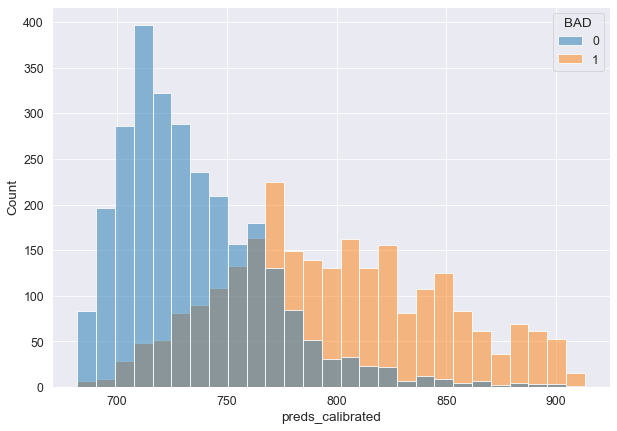

In [10]:
rus = RandomUnderSampler(sampling_strategy=cfg.SAMPLING_STRATEGY)
X_sub, y_sub = rus.fit_resample(X_test, y_test)
print(y_sub.mean())

preds = model.predict_proba(X_sub)[::,1]
preds_calibrated = pd.DataFrame(np.round(28.85*np.log(preds/(1-preds))+765.75), columns=["preds_calibrated"])

fig, axs = plt.subplots(1, 1, figsize=(10,7))
palette ={0: "C0", 1: "C1"}
sns.histplot(data=preds_calibrated, x="preds_calibrated", hue=y_sub['BAD'], palette=palette, ax=axs, bins='auto')

plt.savefig(os.path.join("Graphs", f"Score_distr_{MODEL_NAME}.png"), facecolor="w", dpi=100, bbox_inches = "tight")

In [11]:
# Logistic regression coefficients
coefs = pd.DataFrame(
    zip(X_train.columns, model["lr"].coef_[0]), columns=["Variable", "Coef"]
)

coefs_std = np.std(model[:-1].transform(X_test), 0)*model["lr"].coef_[0]
coefs['Coef_std'] = coefs_std.to_list()

coefs_sorted = coefs.reindex(coefs["Coef_std"].abs().sort_values(ascending=False).index)
coefs_sorted

,Variable,Coef,Coef_std
0,RevolvingUtilizationOfUnsecuredLines,0.661975,0.692568
2,NumberOfTime30-59DaysPastDueNotWorse,0.585262,0.383928
4,NumberOfTimes90DaysLate,0.616954,0.371561
6,NumberOfTime60-89DaysPastDueNotWorse,0.548815,0.293950
3,DebtRatio,0.932268,0.259322
1,age,0.454536,0.258821
5,NumberRealEstateLoansOrLines,0.427432,0.084557
7,NumberOfDependents,0.138809,0.025596


In [12]:
# Save results for final summary
results = {
    "test_gini": test_gini,
    "test_ap": test_ap,
    "optimization_time": 0,
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "precision": precision.tolist(),
    "recall": recall.tolist(),
    "mean_train_gini": scores_gini["train_score"].tolist(),
    "mean_test_gini": scores_gini["test_score"].tolist(),
}

with open(os.path.join("Results", f"Results_{MODEL_NAME}.json"), 'w') as fp:
    json.dump(results, fp)